<a href="https://colab.research.google.com/github/mohamedalaaaz/testpytroch/blob/main/machanicsphysics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Neural network for wavefunction ψ(x)
class SchrodingerNet(nn.Module):
    def __init__(self):
        super(SchrodingerNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
        # Learnable energy eigenvalue
        self.energy = nn.Parameter(torch.tensor([1.0], dtype=torch.float32))

    def forward(self, x):
        return self.net(x)

# Schrödinger residual: -ψ'' + Vψ = Eψ
def schrodinger_loss(model, x, V_fn):
    x.requires_grad_(True)
    psi = model(x)

    # First and second derivatives
    psi_x = autograd.grad(psi, x, torch.ones_like(psi), create_graph=True)[0]
    psi_xx = autograd.grad(psi_x, x, torch.ones_like(psi_x), create_graph=True)[0]

    V = V_fn(x)
    E = model.energy

    # Residual of Schrödinger equation
    residual = -psi_xx + V * psi - E * psi
    loss_eq = torch.mean(residual**2)

    # Boundary conditions: ψ(0) = ψ(1) = 0
    x0 = torch.zeros(1, 1, device=device)
    x1 = torch.ones(1, 1, device=device)
    bc_loss = torch.mean(model(x0)**2) + torch.mean(model(x1)**2)

    # Normalize ψ: ∫|ψ|² dx ≈ 1
    psi_sq = psi**2
    norm = torch.mean(psi_sq)
    norm_loss = (norm - 1.0)**2

    return loss_eq + bc_loss + norm_loss

# Potential: infinite square well (V = 0)
def zero_potential(x):
    return torch.zeros_like(x)

# Training
def train(model, epochs=5000, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        x = torch.linspace(0, 1, 200).view(-1, 1).to(device)
        loss = schrodinger_loss(model, x, zero_potential)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch} | Loss: {loss.item():.6f} | Energy: {model.energy.item():.6f}")

# Instantiate and train
model = SchrodingerNet().to(device)
train(model)


Epoch 0 | Loss: 1.016384 | Energy: 0.999000
Epoch 500 | Loss: 0.932380 | Energy: 1.531408
Epoch 1000 | Loss: 0.876951 | Energy: 2.134892
Epoch 1500 | Loss: 0.807482 | Energy: 2.743770
Epoch 2000 | Loss: 0.728823 | Energy: 3.340988
Epoch 2500 | Loss: 0.645432 | Energy: 3.917630
Epoch 3000 | Loss: 0.561267 | Energy: 4.469972
Epoch 3500 | Loss: 0.482101 | Energy: 4.998007
Epoch 4000 | Loss: 0.401003 | Energy: 5.501891
Epoch 4500 | Loss: 0.329247 | Energy: 5.979609


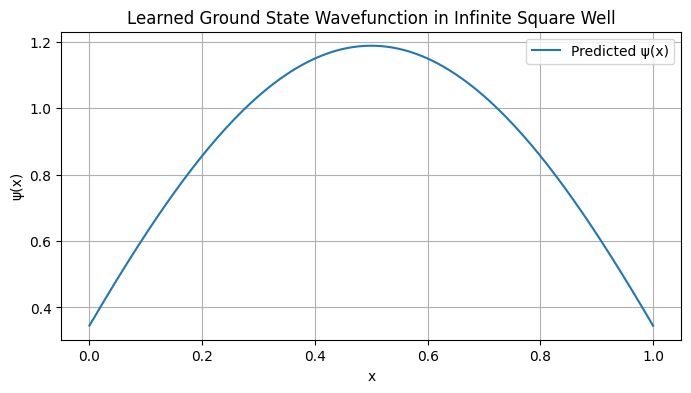

Learned energy eigenvalue: E = 6.432256


In [3]:
# Plot learned ψ(x)
x_test = torch.linspace(0, 1, 200).view(-1, 1).to(device)
with torch.no_grad():
    psi_pred = model(x_test).cpu().numpy()

plt.figure(figsize=(8, 4))
plt.plot(x_test.cpu(), psi_pred, label='Predicted ψ(x)')
plt.title("Learned Ground State Wavefunction in Infinite Square Well")
plt.xlabel("x")
plt.ylabel("ψ(x)")
plt.legend()
plt.grid()
plt.show()

# Print learned energy
print(f"Learned energy eigenvalue: E = {model.energy.item():.6f}")
